In [2]:
# a script to test the changing of the negative prompt
import argparse
from daam import set_seed
from models.diffuserpipeline import StableDiffusionPipelineForNegativePrompts
import torch
import matplotlib.pyplot as plt
import os
import wandb
import math
import random
import matplotlib.patches as patches
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

def get_plt(num):
    plt.clf()
    plt.rcParams.update({'font.size': 10})
    if num < 5:
        fig, axs = plt.subplots(1, num , figsize=(5*num, 5+1))
        for ax in axs:
            ax.axis('off')
    else:
        fig, axs = plt.subplots(math.ceil(num / 4),4)

        for i in range(math.ceil(num / 4)):
            for j in range(4):
                ax = axs[i][j]
                ax.axis('off')
    plt.subplots_adjust(top=0.95)  
    return plt, fig, axs


def get_axs(axs, id, num):
    if num < 4:
        return axs[id]
    else:
        return axs[math.floor(id/4)][id%4]
    
def vector_projection(a, b):
    """
    Project vector a onto vector b.
    """
    return (torch.dot(a, b) / torch.dot(b, b)) * b
    

def projection(x, y):
    batch_size, channels, width, height = x.shape
    x = x.view(channels, width * height)
    y = y.view(channels, width * height)
    
    proj = torch.zeros_like(x)
    
    if batch_size > 1:
        raise NotImplementedError("Batch size > 1 not implemented")
    for i in range(channels):
        proj[i,] = vector_projection(x[i,], y[i,])
        
    x = x.view(batch_size, channels, width, height)
    y = y.view(batch_size, channels, width, height)
    proj = proj.view(batch_size, channels, width, height)
    
    return proj

def projectionalliinone(x, y):
    batch_size, channels, width, height = x.shape
    x = x.reshape(channels * width * height)
    y = y.reshape(channels * width * height)
    
    proj = torch.zeros_like(x)
    
    if batch_size > 1:
        raise NotImplementedError("Batch size > 1 not implemented")
    proj = vector_projection(x, y)
        
    x = x.view(batch_size, channels, width, height)
    y = y.view(batch_size, channels, width, height)
    proj = proj.view(batch_size, channels, width, height)
    
    return proj

model_id = 'stabilityai/stable-diffusion-2-base'
device = 'cuda'
pipe = StableDiffusionPipelineForNegativePrompts.from_pretrained(model_id, use_auth_token=True)
pipe = pipe.to(device)
def exp(bound_box, prompt, negative_prompt, seed, steps, negative_time):
    with torch.cuda.amp.autocast(dtype=torch.float16), torch.no_grad():
        ### plot negative time plot
        fig, axs = plt.subplots(3, 3, figsize=(10, 5+1))
        
        out, _, _, _, _ = pipe.negative_accumulate(prompt, negative_prompt=negative_prompt if len(negative_prompt)> 0 else None, num_inference_steps=steps, generator=set_seed(seed),negative_time=negative_time,output_type='image')
        
        axs[0][0].imshow(out.images[0])
        
        bound_box_image = [tmp*8 for tmp in bound_box]
        mask_image = np.zeros_like(out.images[0])
        mask_image[bound_box_image[1]:bound_box_image[1]+bound_box_image[3],bound_box_image[0]:bound_box_image[0]+bound_box_image[2],:] = 1
        axs[0][2].imshow((out.images[0]*mask_image))
        
        
        ### compute with negative prompt
        out, diffusion_process, negative_noises, positive_noises, uncond_noises = pipe.negative_accumulate(prompt, negative_prompt=negative_prompt if len(negative_prompt)> 0 else None, num_inference_steps=steps, generator=set_seed(seed),negative_time=40,output_type='image')
        
        axs[1][0].imshow(out.images[0])
        
        diffusion_process_draw = []
        for k in range(len(diffusion_process)):
            temp = torch.mean(diffusion_process[k],dim=1,keepdim=True)
            temp = torch.cat([temp]*3,dim=1)
            # scale temp to 0-1
            # temp = (temp - torch.min(temp))/(torch.max(temp) - torch.min(temp))
            diffusion_process_draw.append(temp)
                    
        ## bounding box and mask
        mask_latent = torch.zeros_like(diffusion_process[0]).to(device)
        mask_latent[:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]] = 1
        

        axs[1][1].imshow((diffusion_process_draw[30]*mask_latent[0,0:3]).squeeze(0).cpu().numpy().transpose(1, 2, 0))
        
        mask_image[bound_box_image[1]:bound_box_image[1]+bound_box_image[3],bound_box_image[0]:bound_box_image[0]+bound_box_image[2],:] = 1
        axs[1][2].imshow((out.images[0]*mask_image))
        
        ratiowith = [float(torch.norm(projectionalliinone(positive_noises[k][:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]],negative_noises[k][:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]]))) for k in range(len(positive_noises))]
        
        ### compute without negative prompt
        out, diffusion_process_, negative_noises_, positive_noises_, uncond_noises_ = pipe.negative_accumulate(prompt, negative_prompt=negative_prompt if len(negative_prompt)> 0 else None, num_inference_steps=steps, generator=set_seed(seed),negative_time=0,output_type='image')
        
        axs[2][0].imshow(out.images[0])
        
        diffusion_process_draw_ = []
        for k in range(len(diffusion_process_)):
            temp = torch.mean(diffusion_process_[k],dim=1,keepdim=True)
            temp = torch.cat([temp]*3,dim=1)
            # scale temp to 0-1
            # temp = (temp - torch.min(temp))/(torch.max(temp) - torch.min(temp))
            diffusion_process_draw_.append(temp)
                    
        ## bounding box and mask
        mask_latent_ = torch.zeros_like(diffusion_process_[0]).to(device)
        mask_latent_[:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]] = 1
        

        axs[2][1].imshow((diffusion_process_draw_[30]*mask_latent_[0,0:3]).squeeze(0).cpu().numpy().transpose(1, 2, 0))
        
        bound_box_image_= [tmp*8 for tmp in bound_box]
        mask_image_ = np.zeros_like(out.images[0])
        mask_image_[bound_box_image[1]:bound_box_image[1]+bound_box_image[3],bound_box_image[0]:bound_box_image[0]+bound_box_image[2],:] = 1
        axs[2][2].imshow((out.images[0]*mask_image))
            
        # rect = patches.Rectangle((bound_box[0], bound_box[1]), bound_box[2], bound_box[3], linewidth=1, edgecolor='r', facecolor='none')
        # ax.add_patch(rect)
        ratiowithout = [float(torch.norm(projectionalliinone(positive_noises_[k][:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]],negative_noises_[k][:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]]))) for k in range(len(positive_noises))]
        
        diff = [ratiowith[k] - ratiowithout[k] for k in range(len(ratiowithout))]

        axs[0][1].plot(diff[0:10])
        fig.show()
            

/home/banyh2000/anaconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/banyh2000/anaconda3/envs/ldm/lib/python3.8/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipelineForNegativePrompts and will be ignored.
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  8.91it/s]


In [3]:
def exp_diff(bound_box, prompt, negative_prompt, seed, steps, negative_time):
    with torch.cuda.amp.autocast(dtype=torch.float16), torch.no_grad():
        ### plot negative time plot
        
        out, _, _, _, _ = pipe.negative_accumulate(prompt, negative_prompt=negative_prompt if len(negative_prompt)> 0 else None, num_inference_steps=steps, generator=set_seed(seed),negative_time=negative_time,output_type='image')
        
        
        
        ### compute with negative prompt
        out, diffusion_process, negative_noises, positive_noises, uncond_noises = pipe.negative_accumulate(prompt, negative_prompt=negative_prompt if len(negative_prompt)> 0 else None, num_inference_steps=steps, generator=set_seed(seed),negative_time=40,output_type='image')
        
        diffusion_process_draw = []
        for k in range(len(diffusion_process)):
            temp = torch.mean(diffusion_process[k],dim=1,keepdim=True)
            temp = torch.cat([temp]*3,dim=1)
            diffusion_process_draw.append(temp)
                    
        ## bounding box and mask
        mask_latent = torch.zeros_like(diffusion_process[0]).to(device)
        mask_latent[:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]] = 1
        
        ratiowith = [float(torch.norm(projectionalliinone(positive_noises[k][:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]],negative_noises[k][:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]]))) for k in range(len(positive_noises))]
        
        ### compute without negative prompt
        out, diffusion_process_, negative_noises_, positive_noises_, uncond_noises_ = pipe.negative_accumulate(prompt, negative_prompt=negative_prompt if len(negative_prompt)> 0 else None, num_inference_steps=steps, generator=set_seed(seed),negative_time=0,output_type='image')
        
        
        diffusion_process_draw_ = []
        for k in range(len(diffusion_process_)):
            temp = torch.mean(diffusion_process_[k],dim=1,keepdim=True)
            temp = torch.cat([temp]*3,dim=1)
            # scale temp to 0-1
            # temp = (temp - torch.min(temp))/(torch.max(temp) - torch.min(temp))
            diffusion_process_draw_.append(temp)
                    
        ## bounding box and mask
        mask_latent_ = torch.zeros_like(diffusion_process_[0]).to(device)
        mask_latent_[:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]] = 1
            
        ratiowithout = [float(torch.norm(projectionalliinone(positive_noises_[k][:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]],negative_noises_[k][:, :,bound_box[1]:bound_box[1]+bound_box[3],bound_box[0]:bound_box[0]+bound_box[2]]))) for k in range(len(positive_noises))]
        
        diff = [ratiowith[k] - ratiowithout[k] for k in range(len(ratiowithout))]

        return diff[0:10]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


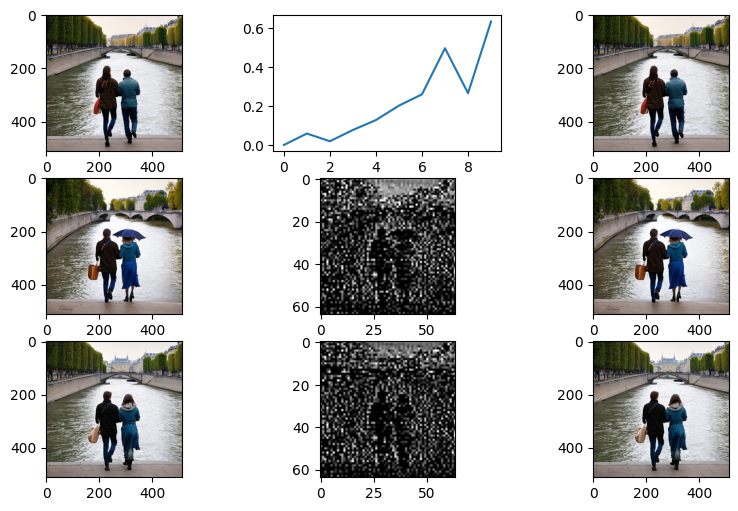

In [4]:
exp(bound_box = [0,0,64,64],
prompt = "a couple walk along the riverside in Paris",
negative_prompt = "Eiffel tower",
seed = 6790000,
steps = 30,
negative_time = 3,
)
# seed = 6793668,

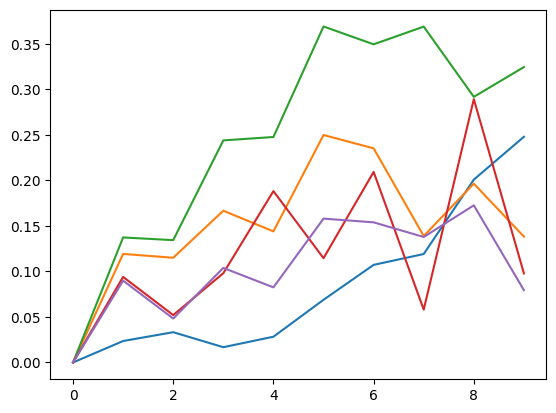

In [8]:
prompts = ["a couple walk along the riverside in Paris","professional office woman","a living room", "office wall above a wooden desk", "a hiker resting on a mountain trail."]
negative_prompts = ["Eiffel tower","glasses","ceiling fan","potted plant","backpack"]
save_dict = []
for prompt,negative_prompt in zip(prompts,negative_prompts):

    diffs = []
    seeds = [random.randint(0,10000000) for i in range(10)]
    for i in range(10):
        tmp = exp_diff(bound_box = [0,0,64,64],
        prompt = prompt,
        negative_prompt = negative_prompt,
        seed = seeds[i],
        steps = 30,
        negative_time = 3,
        )
    # 360290
        diffs.append(tmp)
    diff = np.array(diffs)
    diff = np.mean(diff,axis=0)
    save_dict.append({
        "prompt":prompt,
        "negative_prompt":negative_prompt,
        "diff":diff.tolist(),
        "seeds":seeds
    })
    plt.plot(diff)
plt.show()
import json
with open('how_induce.json', 'w') as f:
    json.dump(save_dict, f)

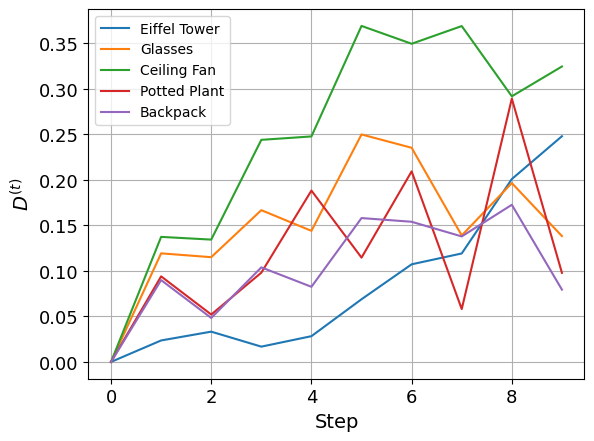

In [2]:
import json
import matplotlib.pyplot as plt
with open('how_induce.json', 'r') as f:
    data = json.load(f)
legend = []
for dict_ in data:
    diff = dict_["diff"]
    plt.plot(diff)
    legend.append(dict_["negative_prompt"].title())
plt.grid()
plt.legend(legend)
plt.xlabel("Step",fontsize=14)
plt.ylabel("$D^{(t)}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig("how_induce.png")